<a href="https://colab.research.google.com/github/trodrigue1304/Fraud_detection_algorithm/blob/rod/source.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Chargement des données et paramétrage de l'environnement de travail**

In [1]:
# Chargement des packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import sklearn as skl
import seaborn as sns
import time
from google.colab import drive
from sklearn.impute import KNNImputer

# Connexion à google drive et importation des données
drive.mount('/content/drive')
id_train=pd.read_csv('/content/drive/My Drive/projet python/train_identity.csv')
tr_train=pd.read_csv('/content/drive/My Drive/projet python/train_transaction.csv')
id_test=pd.read_csv('/content/drive/My Drive/projet python/test_identity.csv')
tr_test=pd.read_csv('/content/drive/My Drive/projet python/test_transaction.csv')

## Affichage de toutes les lignes pour les outputs
pd.options.display.max_rows = 4000

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Première exploration des données**

**Visualisation des données**

In [2]:
id_train.head(10)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS
5,2987017,-5.0,61141.0,3.0,0.0,3.0,0.0,NaN,NaN,3.0,0.0,100.0,NotFound,52.0,-300.0,Found,Found,166.0,18.0,529.0,600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Windows 10,chrome 62.0,24.0,1366x768,match_status:2,T,F,T,T,desktop,Windows
6,2987022,-15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NotFound,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987038,0.0,31964.0,0.0,0.0,0.0,-10.0,NaN,NaN,0.0,0.0,100.0,Found,NaN,-300.0,Found,Found,166.0,15.0,352.0,533.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Android,chrome 62.0,32.0,1920x1080,match_status:2,T,F,T,T,mobile,NaN
8,2987040,-10.0,116098.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
9,2987048,-5.0,257037.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,484.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows


In [3]:
tr_train.head(10)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2987005,0,86510,49.0,W,5937,555.0,150.0,visa,226.0,debit,272.0,87.0,36.0,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2987006,0,86522,159.0,W,12308,360.0,150.0,visa,166.0,debit,126.0,87.0,0.0,NaN,yahoo.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987007,0,86529,422.5,W,12695,490.0,150.0,visa,226.0,debit,325.0,87.0,NaN,NaN,mail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2987008,0,86535,15.0,H,2803,100.0,150.0,visa,226.0,debit,337.0,87.0,NaN,NaN,anonymous.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2987009,0,86536,117.0,W,17399,111.0,150.0,mastercard,224.0,debit,204.0,87.0,19.0,NaN,yahoo.com,NaN,2.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,1.0,0.0,12.0,2.0,61.0,61.0,30.0,318.0,30.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,495.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#verifier que toutes les TransactionID de id_train existe dans tr_train
print("Taille de la base identity : ",id_train.shape)
print("Taille de la base transaction : ",tr_train.shape)
print("Nombre de transactions uniques de la base transaction : ",id_train['TransactionID'].nunique())
print("Nombre de transactions uniques de la base identity : ",tr_train['TransactionID'].nunique())
print("Proportion de transactions avec id information (train): "+"{:.2%}".format(np.sum(tr_train['TransactionID'].isin(id_train['TransactionID'].unique()))/tr_train['TransactionID'].nunique()))
print("Proportion de transactions avec id information (test): "+"{:.2%}".format(np.sum(tr_test['TransactionID'].isin(id_test['TransactionID'].unique()))/tr_test['TransactionID'].nunique()))

Taille de la base identity :  (144233, 41)
Taille de la base transaction :  (590540, 394)
Nombre de transactions uniques de la base transaction :  144233
Nombre de transactions uniques de la base identity :  590540
Proportion de transactions avec id information (train): 24.42%
Proportion de transactions avec id information (test): 28.01%


On remarque qu'il y a des transactions sans informations d'identification. On ne tiendra pas compte de ces données.

**Fusion des bases de données**

In [5]:
train=pd.merge(tr_train,id_train,on="TransactionID",how="right")
test=pd.merge(tr_test,id_test,on="TransactionID",how="right")

**Type des variables**

In [6]:
train.dtypes

TransactionID       int64
isFraud             int64
TransactionDT       int64
TransactionAmt    float64
ProductCD          object
card1               int64
card2             float64
card3             float64
card4              object
card5             float64
card6              object
addr1             float64
addr2             float64
dist1             float64
dist2             float64
P_emaildomain      object
R_emaildomain      object
C1                float64
C2                float64
C3                float64
C4                float64
C5                float64
C6                float64
C7                float64
C8                float64
C9                float64
C10               float64
C11               float64
C12               float64
C13               float64
C14               float64
D1                float64
D2                float64
D3                float64
D4                float64
D5                float64
D6                float64
D7                float64
D8          

**Détection des valeurs manquantes**

In [7]:
missing_data=train.isnull().sum().sum()
total_data=np.product(train.shape)
print("Proportion de données manquantes dans la base : "+"{:.2%}".format(missing_data/total_data))

Proportion de données manquantes dans la base : 26.89%


In [8]:
#Fonction pour la visualition de la répartition des données manquantes
def missing_view(data) :
  null_counts = data.isnull().sum()/len(data)
  plt.figure(figsize=(100,20))
  plt.xticks(np.arange(len(null_counts))+0.5,null_counts.index,rotation='vertical')
  plt.ylabel('Proportion de données manquantes')
  plt.bar(np.arange(len(null_counts)),null_counts)


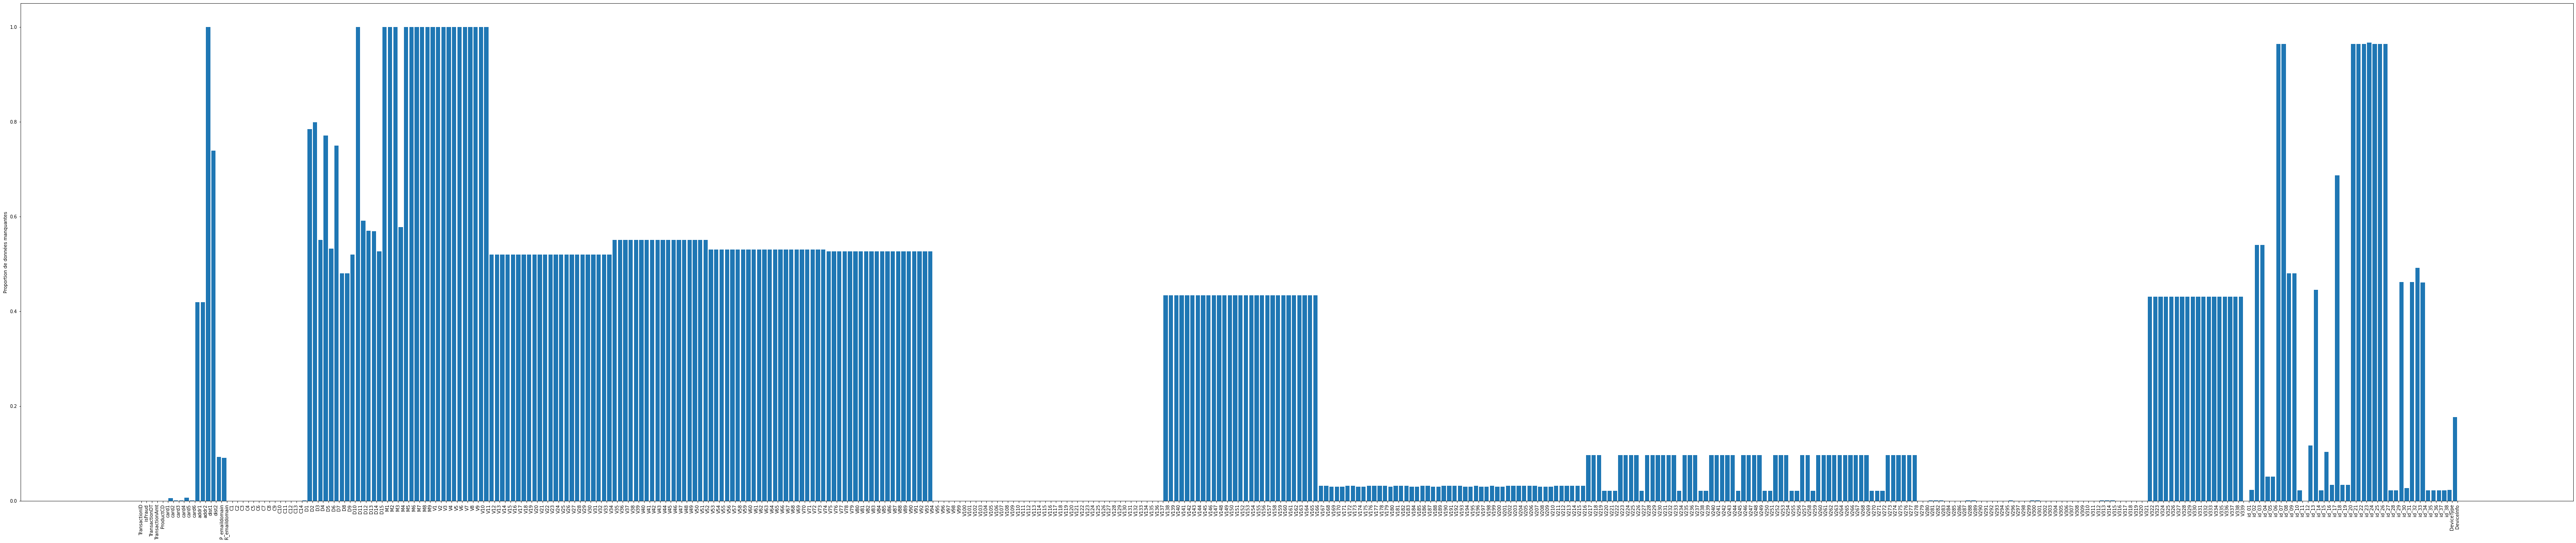

In [9]:
#Visualisation
missing_view(train)

Il faudra donc procéder à un traitement des valeurs manquantes et s'il le faut voir l'impact sur les modèles futurs.

**Analyse de la variable d'intérêt**

In [10]:
#Tableau des effectifs
tab = pd.DataFrame(train.groupby('isFraud').count()['TransactionID'])
tab

,TransactionID
isFraud,
0,132915
1,11318


Text(0.5, 1.0, 'Distribution de la variable isFraud')

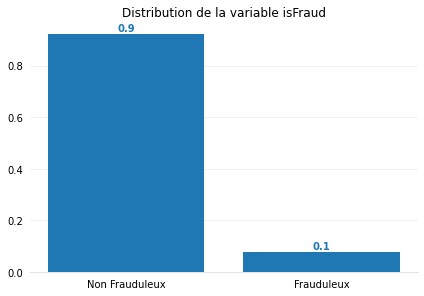

In [11]:
#Visualisation
tab['TransactionID'] = tab['TransactionID']/tab['TransactionID'].sum()
fig, ax = plt.subplots()

# Save the chart so we can loop through the bars below.
bars = ax.bar(
    x=np.arange(tab.size),
    height=tab['TransactionID'],
    tick_label=['Non Frauduleux', 'Frauduleux']
)

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# Grab the color of the bars so we can make the
# text the same color.
bar_color = bars[0].get_facecolor()

# Add text annotations to the top of the bars.
# Note, you'll have to adjust this slightly (the 0.3)
# with different data.
for bar in bars:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 0.01,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color=bar_color,
      weight='bold'
  )

fig.tight_layout()

ax.set_title("Distribution de la variable isFraud")

  On soupçonne un surapprentissage des modèles sur les valeurs non frauduleuses. On recalibre les données de manière à avoir une répartition uniforme.

In [12]:
#Recalibrage
class0=np.where(train['isFraud']==0)[0]
class1=np.where(train['isFraud']==1)[0]
class0_downsample=np.random.choice(class0,size=len(class1),replace=False)
Kept_index=sorted([*class0_downsample,*class1])
train_calibrate=train[train.index.isin(Kept_index)]

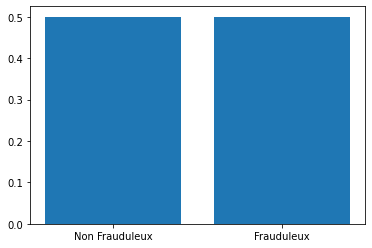

In [13]:
#On s'assure que le tirage a été bien fait
tab = pd.DataFrame(train_calibrate.groupby('isFraud').count()['TransactionID'])
tab['TransactionID'] = tab['TransactionID']/tab['TransactionID'].sum()
fig, ax = plt.subplots()

# Save the chart so we can loop through the bars below.
bars = ax.bar(
    x=np.arange(tab.size),
    height=tab['TransactionID'],
    tick_label=['Non Frauduleux', 'Frauduleux']
)

**Visualisation des données manquantes dans la base recalibré**

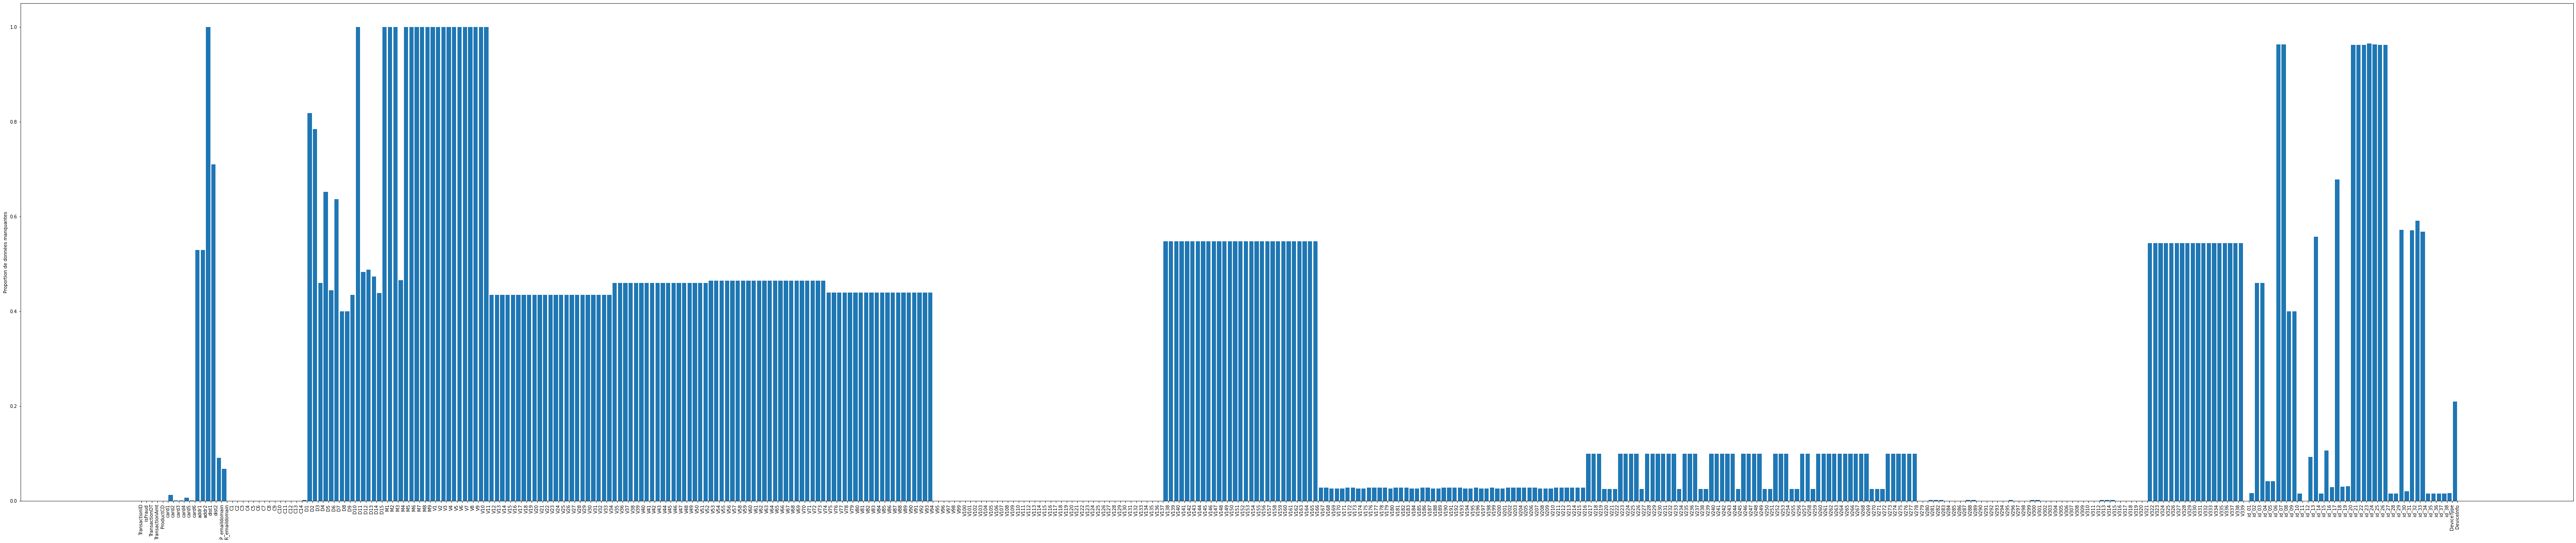

In [14]:
missing_view(train_calibrate)

On remarque que la distribution est quasiment la même avec celle obtenue avant. 
Conclusion : Les données recalibrées sont à l'image des données initiale sur ce plan. On peut donc se restreindre à la nouvelle base pour la suite des travaux.

### **Analyse et traitement des données manquantes**

**Valeurs manquantes suivant la variable d'intérêt**

Text(0.5, 0.98, 'Valeurs manquantes sur les données frauduleuses')

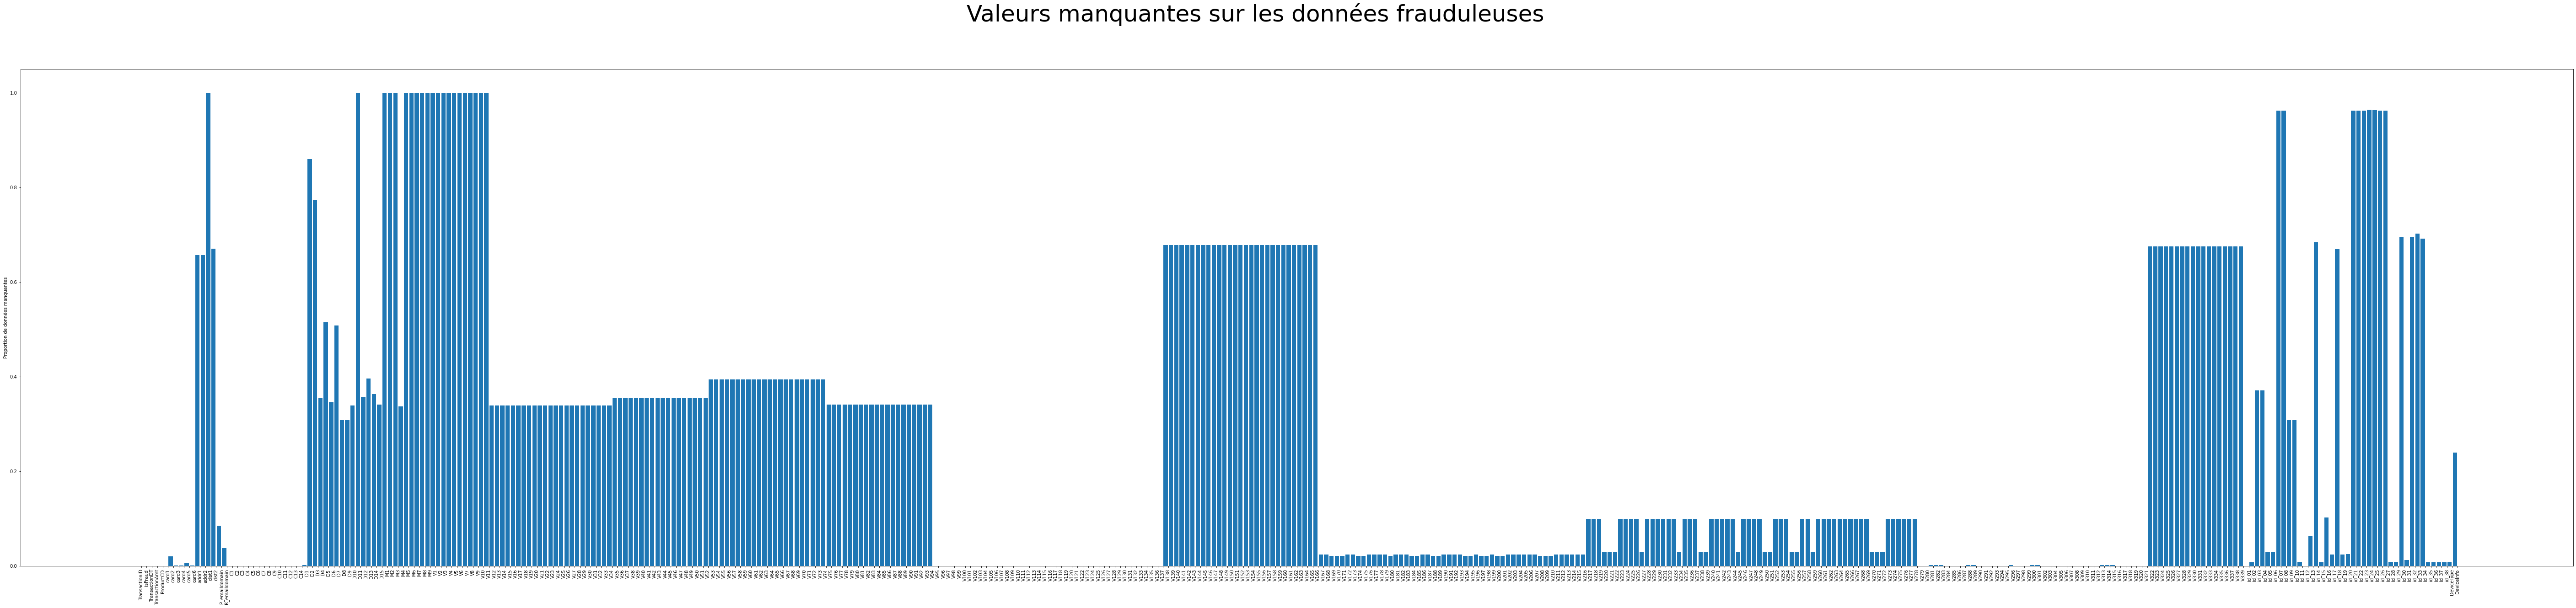

In [15]:
missing_view(train_calibrate[train_calibrate.isFraud == 1])
plt.suptitle("Valeurs manquantes sur les données frauduleuses", fontsize=50)

Text(0.5, 0.98, 'Valeurs manquantes sur les données non frauduleuses')

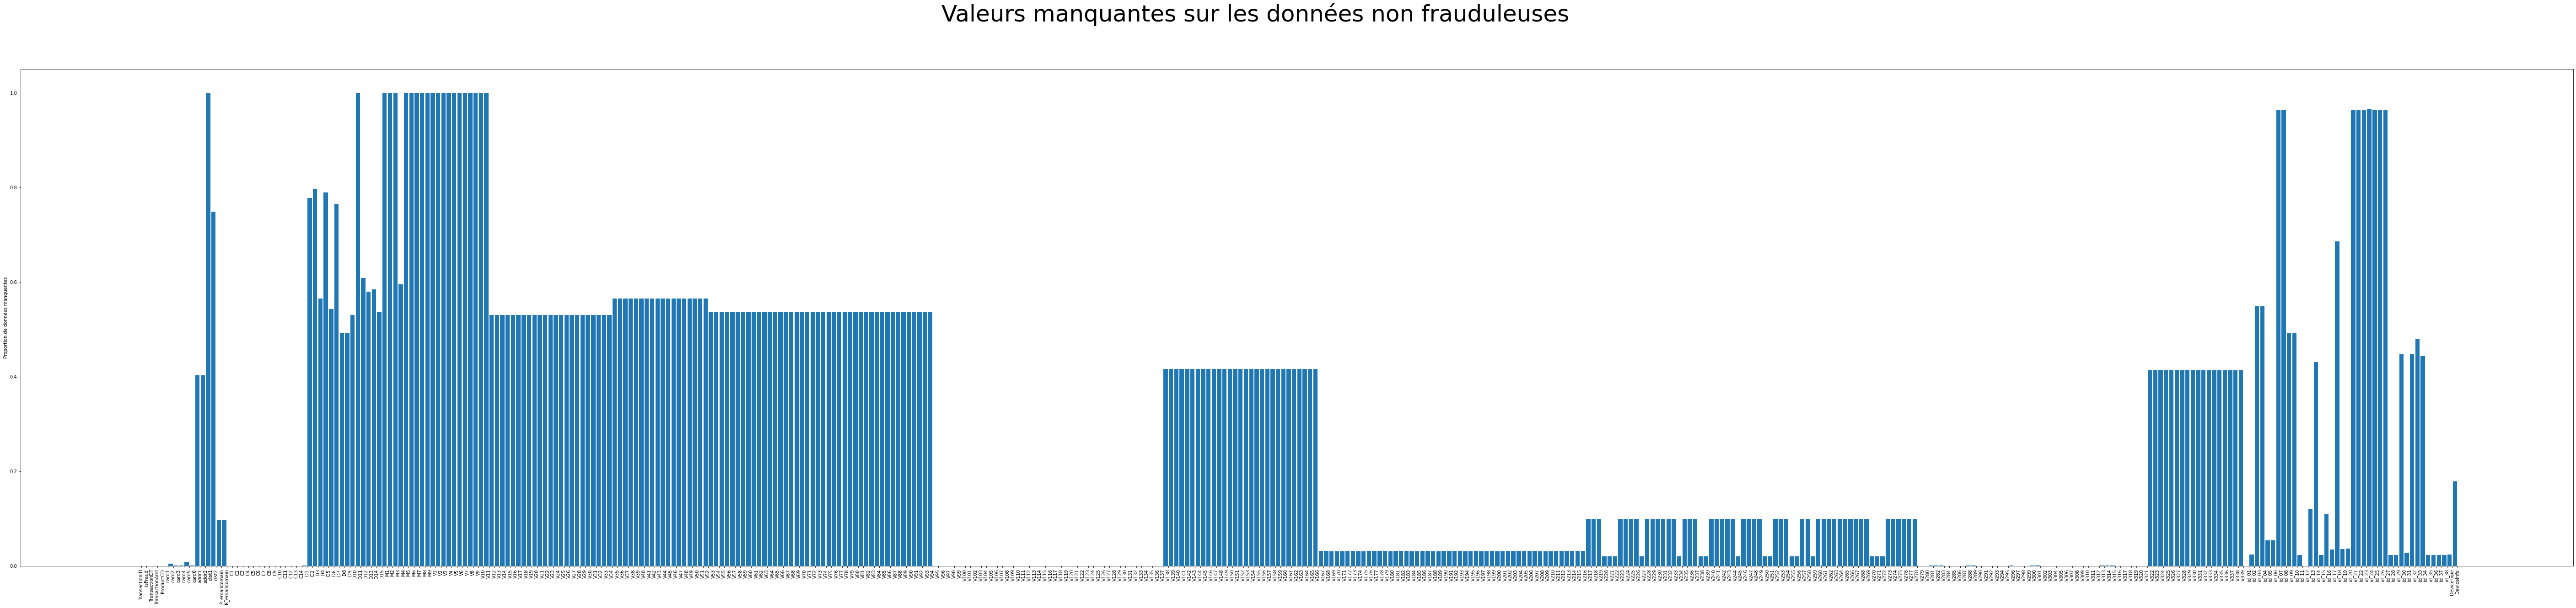

In [16]:
missing_view(train_calibrate[train_calibrate.isFraud == 0])
plt.suptitle("Valeurs manquantes sur les données non frauduleuses", fontsize=50)

De manière générale, on remarque que la représentation est pratiquement la même. On peut dès lors faire une courbe de sensibilité pour voir le nombre de variables par seuil.

**Courbe de sensibilité**

In [17]:
train_column_miss = train_calibrate.isnull().any()
print(f'Nombre de variables avec des données manquantes (apprentissage) : {train_column_miss.sum()} .')

Nombre de variables avec des données manquantes (apprentissage) : 412 .


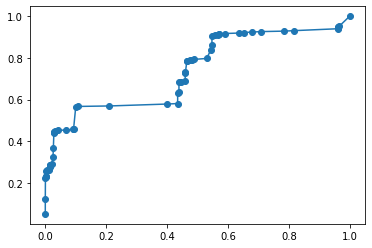

In [18]:
column_miss = train_calibrate.isnull().sum()/train_calibrate.shape[0]
my_series = pd.Series(np.sort(column_miss.values))
sensibility_graph = my_series.value_counts().reset_index().sort_values(by=['index'])
sensibility_graph[0] = np.cumsum(sensibility_graph[0]/sensibility_graph[0].sum())
plt.plot(sensibility_graph['index'], sensibility_graph[0], '-o')

On peut essayer de voir ce qui se passe à partir de 60 % de données manquantes.

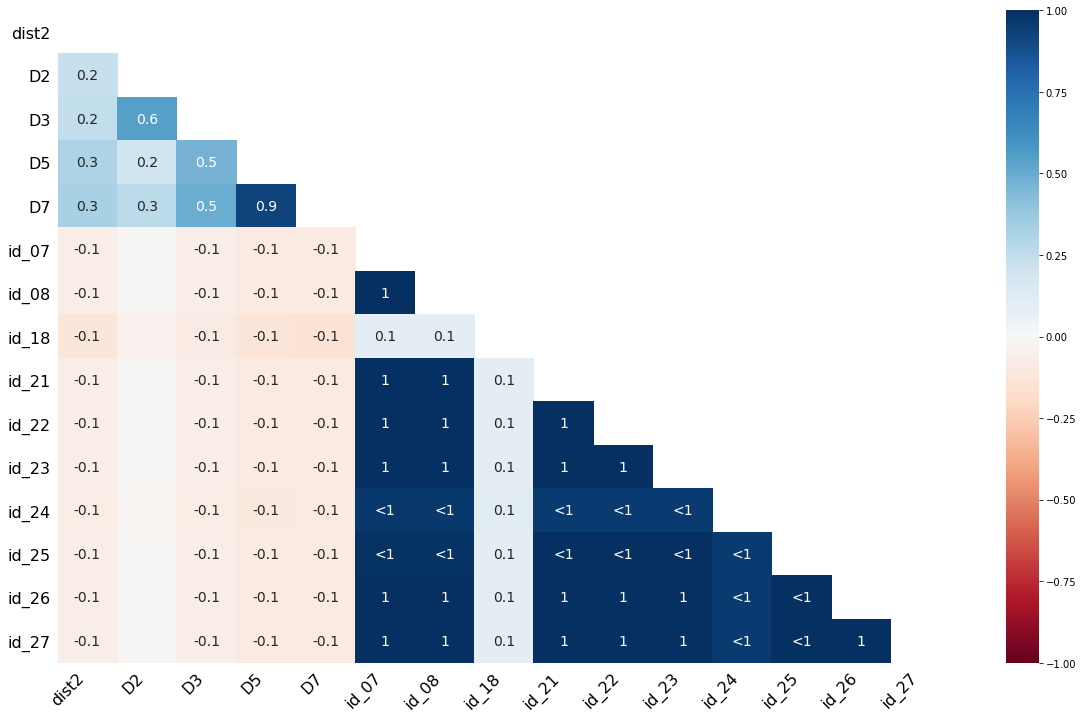

In [19]:
null_counts = train_calibrate.isnull().sum()/len(train_calibrate)
train_data_miss_60 = train_calibrate.filter(items=null_counts[null_counts>=0.6].reset_index()['index'])
msno.heatmap(train_data_miss_60)

On remarque que pour plusieurs des variables, elles prennent conjointement les valeurs manquantes. Couplé au fait que l'apparition des données manquantes est relativement indépendant du caractère frauduleux de la variable, on peut se restreindre aux variables de moins de 60% de valeurs manquantes. De plus, la courbe de sensibilité nous incite à abaisser ce taux à 20% puisqu'il n'y a pas énormément de variables entre 20 et 40%. Une analyse comparative des résultats pourra être ajoutée suivant le seuil choisi.

**Traitement des valeurs manquantes**

In [20]:
###On décide de ne retenir que les variables de moins de 20% de données manquantes et de procéder à une imputation par KNN 
train_work = train_calibrate.filter(items=null_counts[null_counts<0.2].reset_index()['index'])
train_work.shape

(22636, 246)

In [21]:
from sklearn.impute import KNNImputer
train_imputed = KNNImputer(missing_values=np.nan, n_neighbors=5).fit_transform(train_work.select_dtypes(exclude='object'))

In [22]:
train_imputed

array([[2.9870080e+06, 0.0000000e+00, 8.6535000e+04, ..., 1.6600000e+02,
        6.2100000e+02, 5.0000000e+02],
       [2.9870700e+06, 0.0000000e+00, 8.7735000e+04, ..., 1.6600000e+02,
        5.2900000e+02, 5.4900000e+02],
       [2.9870740e+06, 0.0000000e+00, 8.7775000e+04, ..., 2.2500000e+02,
        2.6600000e+02, 3.0500000e+02],
       ...,
       [3.5774650e+06, 0.0000000e+00, 1.5809790e+07, ..., 1.6600000e+02,
        6.2100000e+02, 2.2200000e+02],
       [3.5774860e+06, 0.0000000e+00, 1.5810107e+07, ..., 2.2500000e+02,
        4.2700000e+02, 3.2500000e+02],
       [3.5775260e+06, 1.0000000e+00, 1.5810876e+07, ..., 1.6600000e+02,
        3.5200000e+02, 3.3300000e+02]])

In [23]:
train_imputed = pd.DataFrame(train_imputed)
train_imputed.columns = train_work.select_dtypes(exclude='object').columns
train_imputed = pd.merge(train_imputed,train_work[np.append('TransactionID',train_work.select_dtypes('object').columns.values)],on="TransactionID",how="left")
train_imputed


,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,...,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,id_01,id_02,id_05,id_06,id_11,id_13,id_17,id_19,id_20,ProductCD,card4,card6,P_emaildomain,R_emaildomain,id_12,id_15,id_16,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType
0,2987008.0,0.0,86535.0,15.000,2803.0,100.0,150.0,226.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,98945.0,0.0,-5.0,100.000000,49.0,166.0,621.0,500.0,H,visa,debit,anonymous.com,NaN,NotFound,New,NotFound,New,NotFound,mobile safari 11.0,T,F,F,T,mobile
1,2987070.0,0.0,87735.0,100.000,3682.0,264.0,150.0,162.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,132356.0,1.0,-6.0,100.000000,43.8,166.0,529.0,549.0,H,visa,credit,anonymous.com,NaN,NotFound,New,NotFound,New,NotFound,mobile safari 11.0,T,F,T,T,mobile
2,2987074.0,0.0,87775.0,27.793,15885.0,545.0,185.0,138.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,419136.0,0.0,0.0,100.000000,52.0,225.0,266.0,305.0,C,visa,debit,gmail.com,gmail.com,NotFound,New,NotFound,New,NotFound,chrome 62.0,F,F,T,T,desktop
3,2987099.0,0.0,88162.0,75.000,1214.0,174.0,150.0,226.0,2.0,1.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-10.0,129080.0,9.0,-43.0,100.000000,49.0,166.0,122.0,549.0,R,visa,credit,gmail.com,gmail.com,Found,Found,Found,Found,Found,mobile safari generic,T,F,T,F,mobile
4,2987240.0,1.0,90193.0,37.098,13413.0,103.0,185.0,137.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,169947.0,3.0,0.0,100.000000,44.4,225.0,266.0,325.0,C,visa,credit,hotmail.com,hotmail.com,NotFound,Found,Found,Found,Found,chrome 54.0 for android,F,F,T,T,mobile
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22631,3577418.0,0.0,15808918.0,150.000,7903.0,399.0,150.0,137.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-45.0,118160.0,10.0,-9.0,100.000000,27.0,166.0,321.0,500.0,R,american express,credit,yahoo.com,gmail.com,NotFound,New,NotFound,New,NotFound,chrome 66.0 for android,T,F,T,F,mobile
22632,3577442.0,0.0,15809393.0,100.000,18038.0,520.0,150.0,190.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,17.165221,17.165221,17.165221,0.0,0.0,0.0,0.0,0.0,0.0,-20.0,89189.0,0.2,-0.4,97.559998,63.0,201.4,348.2,317.0,R,american express,credit,anonymous.com,anonymous.com,NotFound,New,NotFound,Found,Found,ie 11.0 for desktop,T,F,F,T,desktop
22633,3577465.0,0.0,15809790.0,250.000,13309.0,399.0,150.0,150.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.

### **Feature Selection**

**Preprocessing of categorical features**

In [24]:
print(train_imputed['P_emaildomain'].value_counts(dropna=False))

gmail.com           10349
hotmail.com          4079
anonymous.com        2065
NaN                  2055
yahoo.com            1426
outlook.com           590
aol.com               438
comcast.net           244
icloud.com            181
yahoo.com.mx           97
msn.com                92
live.com.mx            91
live.com               75
outlook.es             74
verizon.net            74
me.com                 68
sbcglobal.net          57
cox.net                54
mail.com               51
bellsouth.net          51
att.net                46
ymail.com              34
hotmail.es             34
mac.com                31
protonmail.com         29
hotmail.fr             24
charter.net            22
optonline.net          22
web.de                 15
earthlink.net          14
yahoo.fr               13
prodigy.net.mx         13
yahoo.es               10
yahoo.de                9
gmx.de                  8
embarqmail.com          8
hotmail.co.uk           8
suddenlink.net          7
live.fr     

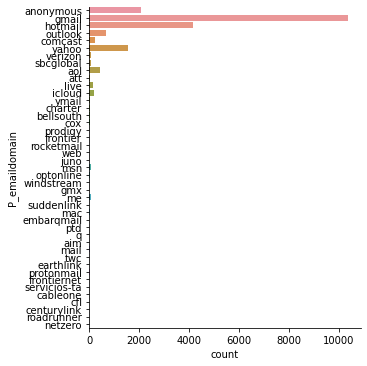

In [25]:
train_imputed['P_emaildomain'] = train_imputed['P_emaildomain'].str.split('.').str.get(0)
sns.catplot(y='P_emaildomain',kind='count',data=train_imputed)

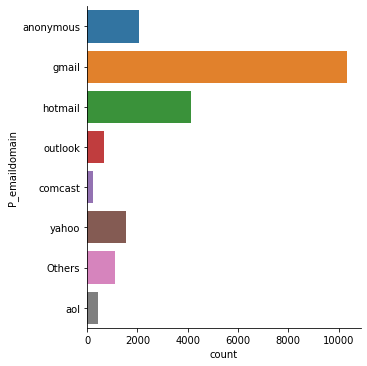

In [26]:
#On regroupe les modalités peu significatives dans autres
prop = train_imputed['P_emaildomain'].value_counts()/len(train_imputed)
train_imputed['P_emaildomain'] = np.where(train_imputed['P_emaildomain'].isin(prop[prop<0.01].reset_index()['index']), 'Others', train_imputed['P_emaildomain'])
sns.catplot(y='P_emaildomain',kind='count',data=train_imputed)

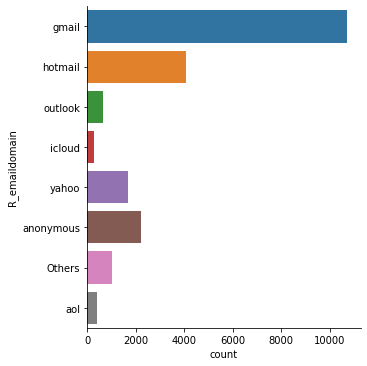

In [27]:
train_imputed['R_emaildomain'] = train_imputed['R_emaildomain'].str.split('.').str.get(0)
prop = train_imputed['R_emaildomain'].value_counts()/len(train_imputed)
train_imputed['R_emaildomain'] = np.where(train_imputed['R_emaildomain'].isin(prop[prop<0.01].reset_index()['index']), 'Others', train_imputed['R_emaildomain'])
sns.catplot(y='R_emaildomain',kind='count',data=train_imputed)

In [28]:
#Traitement textuel de la variable sur les navigateurs
print(train_imputed['id_31'].value_counts(dropna=False))

chrome 63.0                       3192
mobile safari generic             2038
mobile safari 11.0                1943
chrome 65.0                       1242
chrome generic                    1145
chrome 64.0                       1139
chrome 63.0 for android           1087
ie 11.0 for desktop                946
chrome 62.0                        866
safari generic                     858
chrome 64.0 for android            795
chrome 66.0                        738
chrome 65.0 for android            702
chrome 66.0 for android            499
edge 16.0                          487
NaN                                472
firefox 57.0                       415
mobile safari 10.0                 354
chrome 62.0 for android            328
chrome generic for android         215
firefox                            198
edge 15.0                          188
firefox 59.0                       184
samsung browser 6.2                164
firefox 58.0                       137
chrome 61.0 for android  

In [29]:
import re

def ngram(sentence, len_gram):
  """
    Fonction for splitting sentences into d-grammes
  """
  sentence = sentence.strip()
  sentence_split = re.split(r'[/\-,\s]\s*', sentence)
  words = [] 
  if len_gram >= len(sentence.split()) :
    sent_len = 1
  else :
    sent_len = len(sentence.split()) - len_gram +1
  for i in range(sent_len):
      words.append(sentence.split()[i:i+len_gram]) 
  return words

def diff_ngram(sent_a, sent_b, len_gram):
  """
    Fonction to evaluate correspondance between sentences
  """
  a = ngram(sent_a, len_gram)
  b = ngram(sent_b, len_gram) 
  cnt = 0 
  for i in a:
      for j in b:
          if i == j:
              cnt += 1
  return cnt/len(a)

def calculate_similarities(sentences):
  matrix_comparison = np.zeros((len(sentences), len(sentences)))
  for i in range(len(sentences)):
    for j in range(len(sentences)):
      matrix_comparison[i][j] = diff_ngram(sentences[i], sentences[j], 1)
  mat = pd.DataFrame(matrix_comparison).set_index(sentences)
  mat.columns = sentences
  return mat

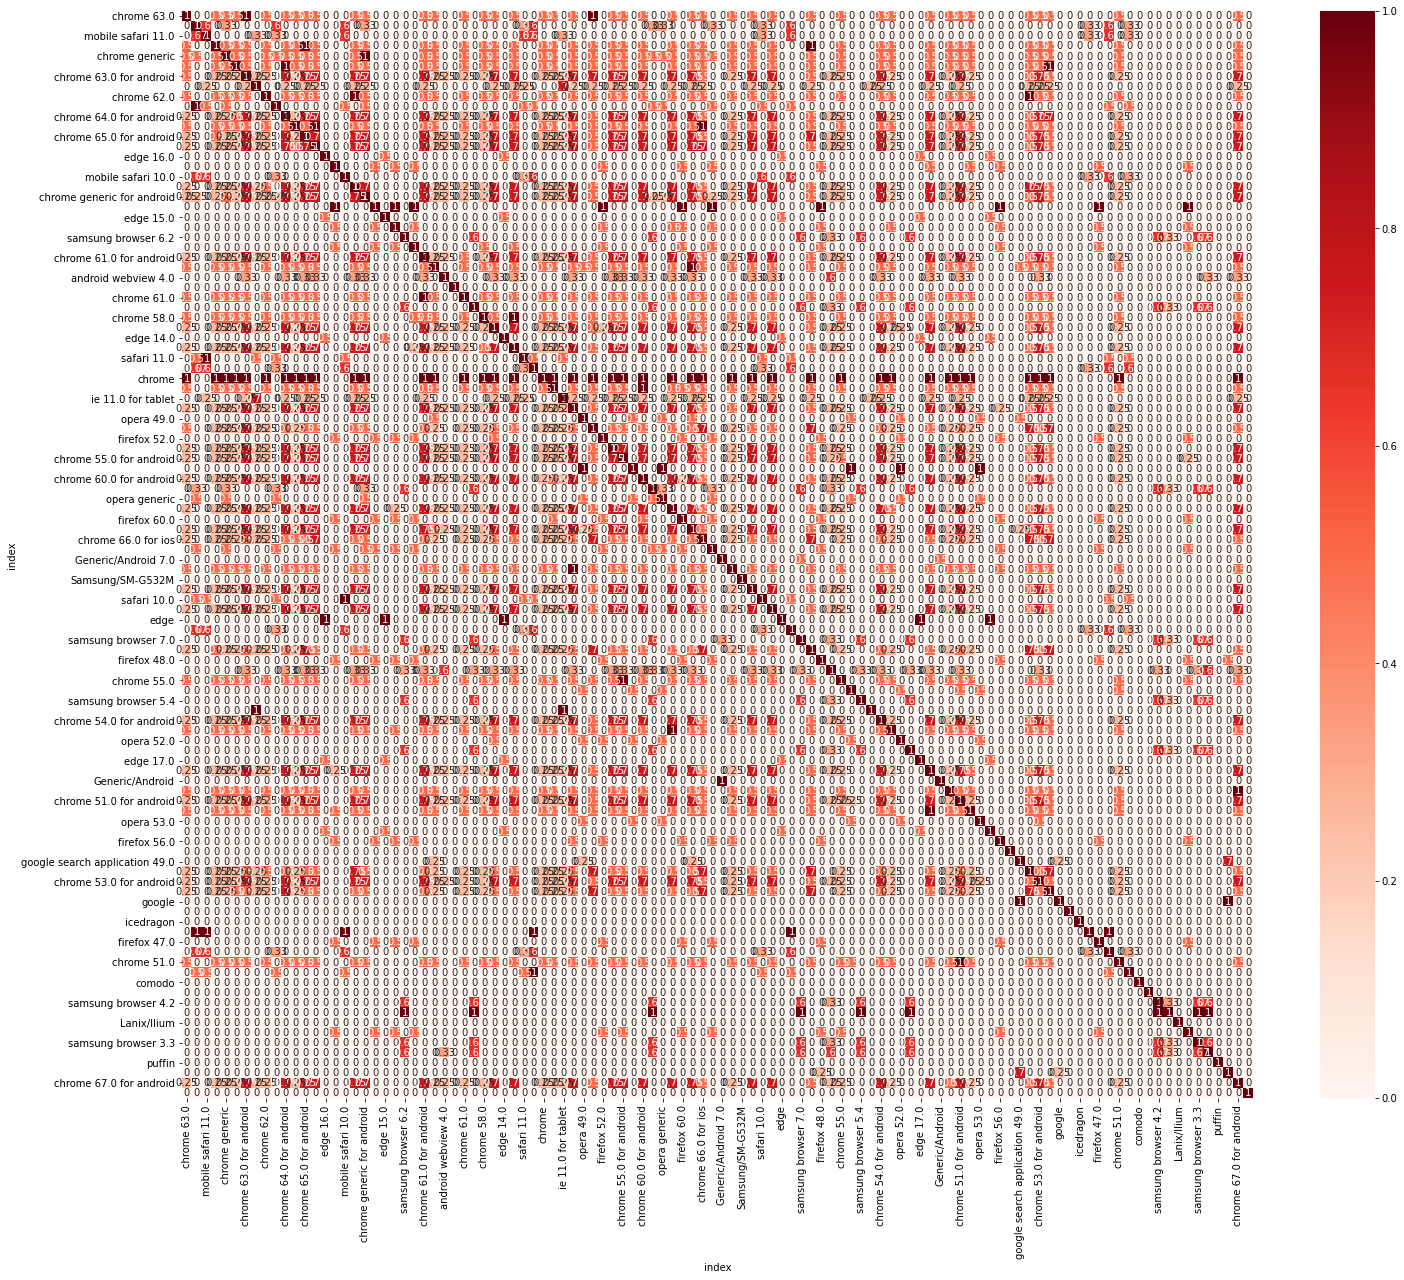

In [30]:
values = train_imputed['id_31'].value_counts().reset_index()['index']
mat = calculate_similarities(values)
plt.figure(figsize=(24,20))
sns.heatmap(mat, annot=True, cmap=plt.cm.Reds)
plt.show()

In [31]:
#Select the max per column
### First we replace on the diagonal the 1 value
i = 0
for var in mat.columns:
  mat[var][i] = 0
  i += 1
mod_list = list()
for var in mat.columns:
  tmp = mat[var][mat[var]>=0.75].reset_index()['index']
  tmp[len(tmp)] = var
  mod_list.append(np.array(tmp))

In [32]:
def common_words(text1, text2) :
  text1_words = text1.strip().split()
  text2_words = text2.strip().split()
  common = set(text1_words).intersection( set(text2_words) )
  text = ' '.join(common).strip()
  return text

In [33]:
prev_value = []
new_value = []

for elt in mod_list :
  if len(elt) > 1 :
    common_text = elt[0]
    for i in range(1,len(elt)) :
      common_text = common_words(common_text, elt[i])
    if common_text.strip() == "" :
      common_text = elt[-1]
    for val in elt :
      prev_value.append(val)
      new_value.append(common_text)

In [34]:
corr_mat = pd.DataFrame(prev_value,new_value).reset_index()
corr_mat.columns = ["New", "Prev"]
corr_mat = corr_mat.drop_duplicates('Prev')

In [35]:
train_imputed_b = pd.merge(train_imputed,corr_mat,how = 'left', left_on='id_31', right_on='Prev')
train_imputed_b['id_31'] = np.where(train_imputed_b['New'].isnull(),train_imputed_b['id_31'],train_imputed_b['New'])
train_imputed_b = train_imputed_b.drop(["New","Prev"], axis= 1)

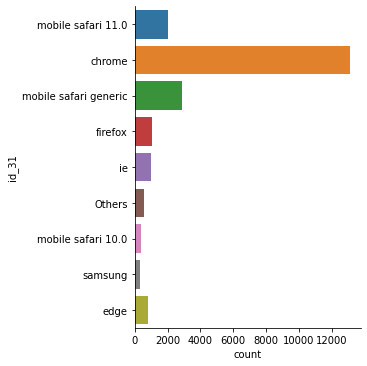

In [36]:
prop = train_imputed_b['id_31'].value_counts()/len(train_imputed_b)
train_imputed_b['id_31'] = np.where(train_imputed_b['id_31'].isin(prop[prop<0.01].reset_index()['index']), 'Others', train_imputed_b['id_31'])
sns.catplot(y='id_31',kind='count',data=train_imputed_b)

In [37]:
#On voit le nombre de modalités par variable
train_imputed_b.select_dtypes('object').nunique()

ProductCD        4
card4            4
card6            3
P_emaildomain    8
R_emaildomain    8
id_12            2
id_15            3
id_16            2
id_28            2
id_29            2
id_31            9
id_35            2
id_36            2
id_37            2
id_38            2
DeviceType       2
dtype: int64

In [38]:
#On met les variables categorielles dans un type exploitable
train_use = train_imputed_b.copy()
quali_col = train_imputed_b.select_dtypes('object').columns
for var in quali_col :
  train_imputed_b[var] = train_imputed_b[var].astype('category')

train_quant = train_imputed_b.drop(quali_col,axis=1)
train_imputed_b = pd.merge(train_quant,pd.get_dummies(train_imputed_b[quali_col]),right_index=True,left_index=True)

### **Logistic Regression (Features Selection and execution)**

In [39]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV
import warnings
warnings.filterwarnings('ignore')

**First execution of Logistic Regression**

In [45]:
time_table = list()

In [41]:
Y_train=train_imputed_b['isFraud'].astype('int')
X_train=train_imputed_b.drop('isFraud',axis=1)
scaler=preprocessing.StandardScaler()
X_train=scaler.fit_transform(X_train)
cv_estimator=LogisticRegression(C=1,random_state=42)

In [42]:
cv_estimator.fit(X_train, Y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [47]:
begin = time.time()
cv_scores = cross_val_score(cv_estimator, X_train, Y_train, cv=5, scoring='roc_auc')
#time_table = time_table.append(["First_logit", time.time - begin])
cv_scores.mean()

0.8656295532503508

In [ ]:
cv_estimator.fit(X_train,Y_train)
importance = cv_estimator.coef_[0]
imp=np.zeros(len(importance))
#plot feature importance
for i,v in enumerate(importance):
  imp[i]='%.5f' % (v)
fig_dims = (40, 40)
fig, ax = plt.subplots(figsize=fig_dims) 
ax = sns.barplot(x=imp, y=list(X_train.columns),ax=ax)

**Recursive Feature Elimination with Cross Validation**

In [ ]:
begin = time.time()
cv_selector = RFECV(cv_estimator,cv= 5, step=1,scoring="F1")
cv_selector = cv_selector.fit(X_train, Y_train)
rfecv_mask = cv_selector.get_support() #list of booleans
rfecv_features = [] 
for bool, feature in zip(rfecv_mask, X_train.columns):
 if bool:
   rfecv_features.append(feature)
time = time.append(["RFECV_logit", time.time - begin])
print("Optimal number of features :", cv_selector.n_features_)
print("Best features :", rfecv_features)


**Model with best features from RFECV**

In [47]:
X_train1=X_train.filter(rfecv_features,axis=1)
cv_scores = cross_val_score(cv_estimator, X_train1, Y_train, cv=5, scoring='roc_auc')
cv_scores.mean()#verification que le score reste le meme

0.8150080053950504

**Feature importance**

### **Random Forest (Features Selection and execution)**

In [ ]:
cv_estimator = RandomForestClassifier(random_state =42)
cv_estimator.fit(X_train, Y_train)
cv_selector = RFECV(cv_estimator,cv= 5, step=1,scoring=’accuracy’)
cv_selector = cv_selector.fit(X_train, Y_train)
rfecv_mask = cv_selector.get_support() #list of booleans
rfecv_features = [] 
for bool, feature in zip(rfecv_mask, X_train.columns):
 if bool:
 rfecv_features.append(feature)
print(‘Optimal number of features :’, cv_selector.n_features_)
print(‘Best features :’, rfecv_features)
n_features = X_train.shape[1]
plt.figure(figsize=(8,8))
plt.barh(range(n_features), cv_estimator.feature_importances_, align='center') 
plt.yticks(np.arange(n_features), X_train.columns.values) 
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

In [ ]:
#Plot best features
n_features = X_train.shape[1]
plt.figure(figsize=(8,8))
plt.barh(range(n_features), cv_estimator.feature_importances_, align='center') 
plt.yticks(np.arange(n_features), X_train.columns.values) 
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

**categorical features**

C    12230
R     4528
H     4309
S     1569
Name: ProductCD, dtype: int64


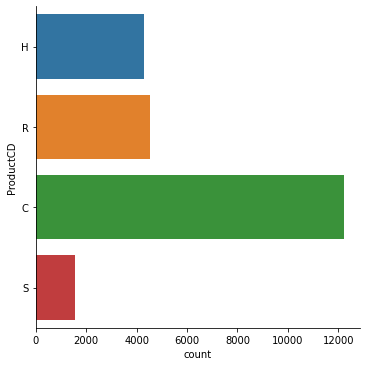

In [ ]:
print(train_imputed['ProductCD'].value_counts(dropna=False))
sns.catplot(y='ProductCD',kind='count',data=train_imputed)
  

visa                13925
mastercard           7387
american express      938
discover              352
NaN                    34
Name: card4, dtype: int64


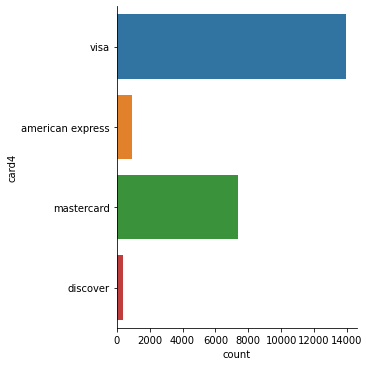

In [ ]:
print(train_imputed['card4'].value_counts(dropna=False))
sns.catplot(y='card4',kind='count',data=train_imputed)

credit         12625
debit           9979
NaN               31
charge card        1
Name: card6, dtype: int64


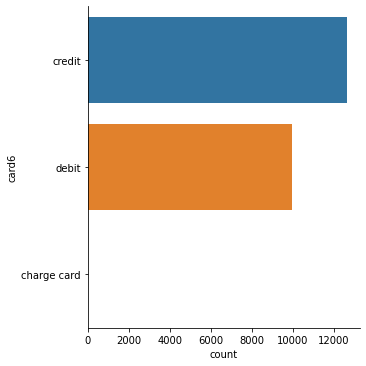

In [ ]:
print(train_imputed['card6'].value_counts(dropna=False))
sns.catplot(y='card6',kind='count',data=train_imputed)

NotFound    19607
Found        3029
Name: id_12, dtype: int64


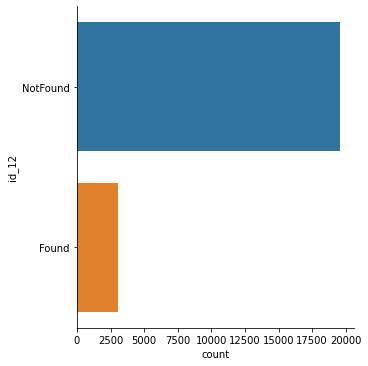

In [ ]:
print(train_imputed['id_12'].value_counts(dropna=False))
sns.catplot(y='id_12',kind='count',data=train_imputed)

Found      12268
New         8071
Unknown     1933
NaN          364
Name: id_15, dtype: int64


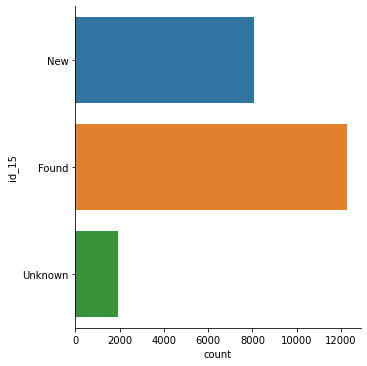

In [ ]:
print(train_imputed['id_15'].value_counts(dropna=False))
sns.catplot(y='id_15',kind='count',data=train_imputed)

Found       12140
NotFound     8199
NaN          2297
Name: id_16, dtype: int64


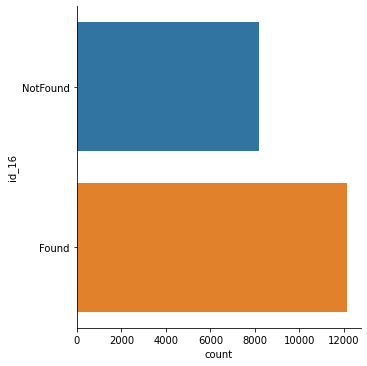

In [ ]:
print(train_imputed['id_16'].value_counts(dropna=False))
sns.catplot(y='id_16',kind='count',data=train_imputed)

Found    13680
New       8588
NaN        368
Name: id_28, dtype: int64


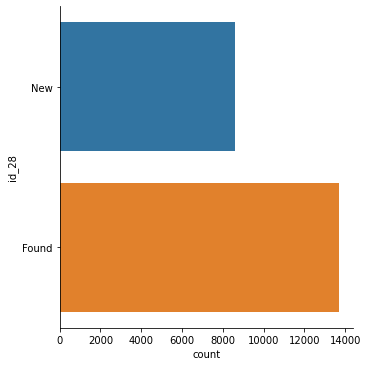

In [ ]:
print(train_imputed['id_28'].value_counts(dropna=False))
sns.catplot(y='id_28',kind='count',data=train_imputed)

Found       13563
NotFound     8705
NaN           368
Name: id_29, dtype: int64


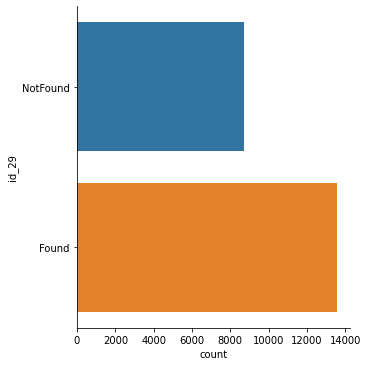

In [ ]:
print(train_imputed['id_29'].value_counts(dropna=False))
sns.catplot(y='id_29',kind='count',data=train_imputed)

F      12382
T       9890
NaN      364
Name: id_35, dtype: int64


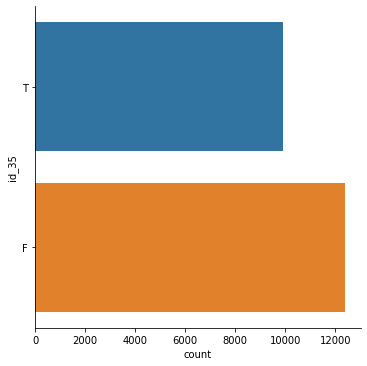

In [ ]:
print(train_imputed['id_35'].value_counts(dropna=False))
sns.catplot(y='id_35',kind='count',data=train_imputed)

F      21486
T        786
NaN      364
Name: id_36, dtype: int64


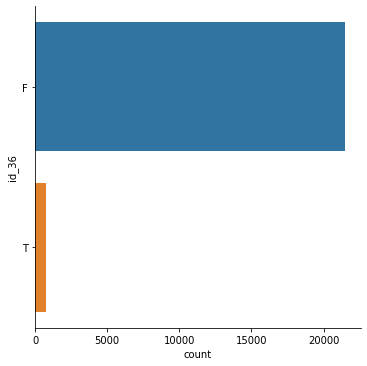

In [ ]:
print(train_imputed['id_36'].value_counts(dropna=False))
sns.catplot(y='id_36',kind='count',data=train_imputed)

T      17846
F       4426
NaN      364
Name: id_37, dtype: int64


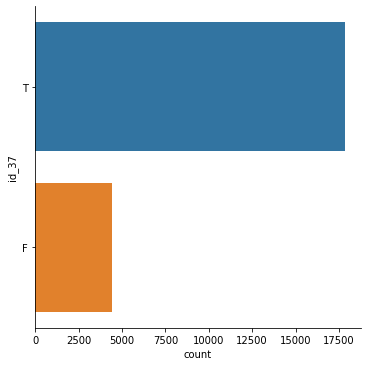

In [ ]:
print(train_imputed['id_37'].value_counts(dropna=False))
sns.catplot(y='id_37',kind='count',data=train_imputed)

F      12911
T       9361
NaN      364
Name: id_38, dtype: int64


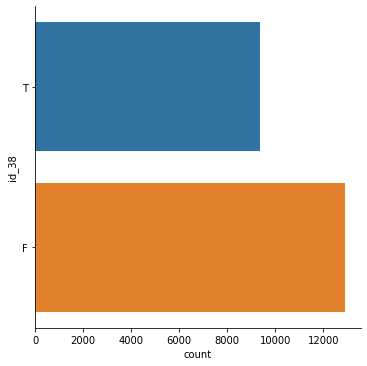

In [ ]:
print(train_imputed['id_38'].value_counts(dropna=False))
sns.catplot(y='id_38',kind='count',data=train_imputed)

desktop    12414
mobile      9833
NaN          389
Name: DeviceType, dtype: int64


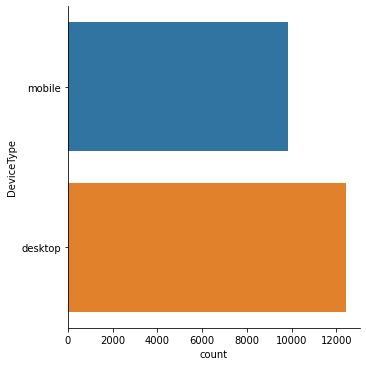

In [ ]:
print(train_imputed['DeviceType'].value_counts(dropna=False))
sns.catplot(y='DeviceType',kind='count',data=train_imputed)